# Transformers

This notebook implements a deep learning model using a Transformer architecture to predict protein secondary structure from amino acid sequences.

## Step 1: Setting up and loading required libraries

In [ ]:
import pickle
import math
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {device}")

PyTorch version: 2.5.1
Device available: cuda


## Step 2: Load the dataset and preprocess data


Here, we define a function to load a pickle file, which is called when a `Dataset` class is instantiated. This class also provides access to public functions `__len__` and `__getitem__` which can help access attributes of the dataset. These methods are also required by PyTorch Dataset.

In [2]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var

# class to index loaded dataset
class ProteinDataset(Dataset):
    def __init__(self, path_to_pkl):
        self.data = load_from_pkl(path_to_pkl)
        self.ids = list(self.data.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id = self.ids[index]
        dict = self.data[id]
        seq = dict["sequence"]
        length = len(seq)
        secstr = dict["secstr"]

        seq = torch.tensor(seq, dtype=torch.long)
        secstr = torch.tensor(secstr, dtype=torch.long)

        return seq, secstr, length
    
train = ProteinDataset('../../datasets/protein-secondary-structure-train.pkl')
val = ProteinDataset('../../datasets/protein-secondary-structure-val.pkl')
test = ProteinDataset('../../datasets/protein-secondary-structure-test.pkl')

### Data Exploration, before preprocessing

Convert the dataset into a pandas dataframe. Extract sequences, secondary structure labels and sequence lengths. Find the maximum sequence length for padding purposes.

In [3]:
batch_size = 256

training_data = {
    "Sequence": [],
    "Secondary Structure": [],
    "Length": []
}

for i in range(train.__len__()):
    seq, secstr, length = train[i]
    training_data["Sequence"].append(seq)
    training_data["Secondary Structure"].append(secstr)
    training_data["Length"].append(length)

train_df = pd.DataFrame(training_data)
print(train_df.head())
max_sequence_length = train_df['Length'].max()

print(f'Max sequence length in training data: {max_sequence_length}')

                                            Sequence  \
0  [tensor(10), tensor(2), tensor(1), tensor(7), ...   
1  [tensor(5), tensor(3), tensor(19), tensor(12),...   
2  [tensor(15), tensor(13), tensor(2), tensor(14)...   
3  [tensor(9), tensor(8), tensor(6), tensor(0), t...   
4  [tensor(15), tensor(15), tensor(16), tensor(18...   

                                 Secondary Structure  Length  
0  [tensor(0), tensor(2), tensor(2), tensor(2), t...      62  
1  [tensor(0), tensor(0), tensor(0), tensor(0), t...     315  
2  [tensor(0), tensor(0), tensor(6), tensor(5), t...     148  
3  [tensor(0), tensor(2), tensor(2), tensor(2), t...     344  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...      75  
Max sequence length in training data: 696


Visualizing secondary structure distribution in the training data:

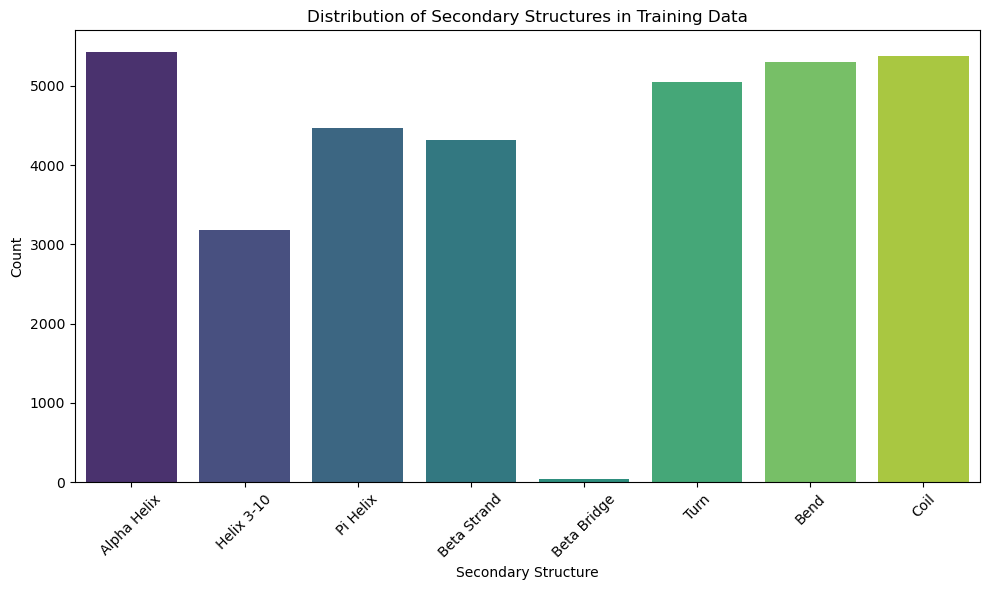

In [4]:
secstr_labels = [
    "Alpha Helix", "Helix 3-10", "Pi Helix", "Beta Strand",
    "Beta Bridge", "Turn", "Bend", "Coil"
]

# Count how many sequences contain each secondary structure type
secstr_counts = {
    name: sum(i in secstr for secstr in train_df['Secondary Structure'])
    for i, name in enumerate(secstr_labels)
}

# Convert to DataFrame for plotting
secstr_df = pd.DataFrame.from_dict(secstr_counts, orient='index', columns=['Count']).reset_index()
secstr_df.rename(columns={'index': 'Secondary Structure'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Secondary Structure', y='Count', data=secstr_df, palette='viridis', hue='Secondary Structure', dodge=False)
plt.xticks(rotation=45)
plt.title('Distribution of Secondary Structures in Training Data')
plt.xlabel('Secondary Structure')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('secstr_distribution.png')
plt.show()


# Step 3: Set the model hyperparameters and make dataloaders

In [5]:
# Model constants
PAD_IDX = 21
NUM_AMINO_ACIDS = 21
NUM_EMBEDDINGS = NUM_AMINO_ACIDS + 1  # +1 for padding
NUM_CLASSES = 8

batch_size = 16  # Smaller batch size for larger model and better gradient updates
learning_rate = 5e-4
num_epochs = 30
weight_decay = 1e-3

Made a custom collate function and initialized dataloaders

In [6]:
def collate_fn(batch):
    """Custom collate function for padding sequences"""
    seqs, labels, lengths = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=PAD_IDX)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=PAD_IDX)
    return seqs_padded, labels_padded

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 340
Validation batches: 15
Test batches: 17


## Step 4: Define the model architecture, loss criterion and optimizer

### Positional Encoding

We experiment with three different types of positional encoding methods:
- Sinusoidal: Classic form of positional encoding, introduced first in the "Attention is all you need" paper. Purely deterministic encodings which encode on the basis of sine / cosine functions with different frequencies.
- Learned Embeddings: Each position index has a trainable embedding vector. Parameters are learned during training, and therefore these encodings are capable of learning task-specific patterns. Issue of generalizability arises.
- RoPE (Rotary Positional Embeddings): Also fixed. Encodes *relative* positions by rotating pairs of embedding dimensions by using sine/cosine. Integrates it directly into attention scores.


In [ ]:
class PositionalEncoding(nn.Module):
    """
    Supports:
     - mode='sinusoidal'  : classic fixed sin/cos positional encodings (added to embeddings)
     - mode='learned'     : learned nn.Embedding(max_len, d_model)
     - mode='none'        : no positional addition (useful when using RoPE)
    """
    def __init__(self, embedding_dim, max_len=2000, mode='sinusoidal'):
        super().__init__()
        assert mode in ('sinusoidal', 'learned', 'none')
        self.mode = mode
        self.embedding_dim = embedding_dim
        self.max_len = max_len

        if mode == 'sinusoidal':
            pos_emb = torch.zeros(max_len, embedding_dim)
            position = torch.arange(0, max_len).unsqueeze(1).float()
            div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() *
                                 -(torch.log(torch.tensor(10000.0)) / embedding_dim))
            pos_emb[:, 0::2] = torch.sin(position * div_term)
            pos_emb[:, 1::2] = torch.cos(position * div_term)
            # (1, max_len, d_model)
            self.register_buffer('pos_emb', pos_emb.unsqueeze(0))
        elif mode == 'learned':
            self.pos_embedding = nn.Embedding(max_len, embedding_dim)
            # init similar to transformer practice
            nn.init.normal_(self.pos_embedding.weight, mean=0.0, std=0.02)
        else:
            pass
    
    def forward(self, x):
        if self.mode == 'none':
            return x
        elif self.mode == 'sinusoidal':
            seq_len = x.size(1)
            return x + self.pos_emb[:, :seq_len].to(x.dtype).to(x.device)
        else:  # learned
            seq_len = x.size(1)
            positions = torch.arange(seq_len, device=x.device).unsqueeze(0)  # (1, S)
            pos_vec = self.pos_embedding(positions)  # (1, S, d_model)
            return x + pos_vec.to(x.dtype)

#### RoPE with Manually coded Multi-Headed attention to apply RoPE to q/k pre-attention

In [8]:
class RotaryPositionalEmbedding(nn.Module):
    """
    Precompute cos/sin matrices for RoPE.
    Assumes head_dim is even.
    Usage: cos, sin buffers shaped to apply to q/k.
    """
    def __init__(self, dim, max_len=2000):
        """
        dim: head_dim (must be even)
        """
        super().__init__()
        assert dim % 2 == 0, "RoPE head_dim must be even"
        self.dim = dim
        self.max_len = max_len

        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        angles = torch.einsum('n,d->n d', t, inv_freq)  # (max_len, dim/2)
        cos = torch.cos(angles)  # (max_len, dim/2)
        sin = torch.sin(angles)  # (max_len, dim/2)

        self.register_buffer('cos', cos)
        self.register_buffer('sin', sin)

    def apply_rotary(self, x, seq_len=None):
        """
        Apply rotary to x.
        x shape: (..., seq_len, head_dim) or (B, seq_len, num_heads, head_dim)
        We'll support x shaped (B, seq_len, num_heads, head_dim) or (B, seq_len, head_dim)
        Returns tensor with same shape.
        """
        if seq_len is None:
            seq_len = x.size(-2)
        # get cos/sin for seq_len: (seq_len, dim/2)
        cos = self.cos[:seq_len]  # (S, d/2)
        sin = self.sin[:seq_len]
        # reshape cos/sin to broadcast: (S, 1, d/2) or (S, 1, 1, d/2) as needed
        # We'll split x into even/odd dims
        original_shape = x.shape
        head_dim = x.size(-1)
        assert head_dim == self.dim, f"head_dim mismatch: {head_dim} vs {self.dim}"

        # split last dim into (d/2, 2) -> even/odd interleaving
        x1 = x[..., 0::2]  # (..., d/2)
        x2 = x[..., 1::2]  # (..., d/2)

        # make cos/sin broadcastable to x1/x2
        # cos: (S, d/2) -> (1, S, 1, d/2) or (S, d/2) depending on x dims
        if x.dim() == 4:
            # (B, S, num_heads, head_dim)
            cos = cos.unsqueeze(1).unsqueeze(0)  # (1, S, 1, d/2)
            sin = sin.unsqueeze(1).unsqueeze(0)
        elif x.dim() == 3:
            # (B, S, head_dim)
            cos = cos.unsqueeze(0).unsqueeze(0)  # (1, S, d/2) -> will broadcast
            sin = sin.unsqueeze(0).unsqueeze(0)
        else:
            # fallback
            cos = cos.unsqueeze(0)
            sin = sin.unsqueeze(0)

        # rotary: [x1, x2] -> [x1 * cos - x2 * sin, x1 * sin + x2 * cos]
        xr1 = x1 * cos - x2 * sin
        xr2 = x1 * sin + x2 * cos

        # interleave xr1/xr2 back to last dim
        # create tensor of shape (..., head_dim)
        out = torch.zeros_like(x)
        out[..., 0::2] = xr1
        out[..., 1::2] = xr2
        return out

class MultiHeadSelfAttention(nn.Module):
    """
    Manual multi-head self-attention so we can apply RoPE to q/k pre-attention.
    batch_first: inputs are (B, S, D)
    key_padding_mask: boolean (B, S) True=pad
    """
    def __init__(self, embedding_dim, num_heads, dropout=0.0, use_rope=False, max_len=2000):
        super().__init__()
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads"
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.scale = 1.0 / math.sqrt(self.head_dim)
        self.use_rope = use_rope

        # qkv projections (we'll project x -> q,k,v then split heads)
        self.q_proj = nn.Linear(embedding_dim, embedding_dim, bias=True)
        self.k_proj = nn.Linear(embedding_dim, embedding_dim, bias=True)
        self.v_proj = nn.Linear(embedding_dim, embedding_dim, bias=True)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim, bias=True)
        self.attn_dropout = nn.Dropout(dropout)
        self.out_dropout = nn.Dropout(dropout)

        if use_rope:
            # Rotary embedding defined per head (head_dim must be even)
            assert self.head_dim % 2 == 0, "Head dim must be even for RoPE"
            self.rope = RotaryPositionalEmbedding(self.head_dim, max_len=max_len)
        else:
            self.rope = None

    def forward(self, x, key_padding_mask=None):
        """
        x: (B, S, D)
        key_padding_mask: (B, S) with True at positions that should be masked (padding)
        returns: attn_out: (B, S, D), attn_weights (B, num_heads, S, S)
        """
        B, S, D = x.shape
        H = self.num_heads
        hd = self.head_dim

        # project
        q = self.q_proj(x)  # (B, S, D)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # reshape to (B, S, H, hd)
        q = q.view(B, S, H, hd)
        k = k.view(B, S, H, hd)
        v = v.view(B, S, H, hd)

        # optionally apply RoPE to q and k
        if self.rope is not None:
            q = self.rope.apply_rotary(q, seq_len=S)  # (B, S, H, hd)
            k = self.rope.apply_rotary(k, seq_len=S)

        # transpose for attention compute: (B, H, S, hd)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        # scaled dot-product: (B, H, S, S)
        attn_scores = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        # mask padding tokens: set score very negative where key is padding
        if key_padding_mask is not None:
            # key_padding_mask: (B, S) True=pad
            # expand to (B, 1, 1, S) then broadcast
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,S)
            attn_scores = attn_scores.masked_fill(mask, float('-inf'))

        attn_probs = F.softmax(attn_scores, dim=-1)  # (B, H, S, S)
        attn_probs = self.attn_dropout(attn_probs)

        # (B, H, S, hd)    
        attn_out = torch.einsum('bhij,bhjd->bhid', attn_probs, v)


        # combine heads -> (B, S, D)
        attn_out = attn_out.permute(0, 2, 1, 3).contiguous().view(B, S, D)
        attn_out = self.out_proj(attn_out)
        attn_out = self.out_dropout(attn_out)

        return attn_out, attn_probs


#### Single Transformer layer.

Allows the option to use RoPE with other encoding methods.

In [9]:
class TransformerLayer(nn.Module):
    "Single Transformer encoder layer with optional RoPE attention"
    def __init__(self, embedding_dim, num_heads, hidden_dim, dropout=0.1,
                 use_rope=False, max_len=2000):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(embedding_dim, num_heads,
                                                dropout=dropout,
                                                use_rope=use_rope,
                                                max_len=max_len)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x, mask=None):
        attn_out, _ = self.self_attn(x, key_padding_mask=mask)
        x = self.norm1(x + self.dropout1(attn_out))

        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_out))

        return x

In [10]:
class Transformer(nn.Module):
    "Transformer model for secondary structure prediction with flexible pos encodings"
    def __init__(self, vocab_size=NUM_EMBEDDINGS, embedding_dim=256, num_heads=8,
                 hidden_dim=1024, num_layers=8, num_classes=NUM_CLASSES, dropout=0.1,
                 pos_mode='sinusoidal', max_len=2000, pad_idx=0, use_rope=False):
        """
        pos_mode: 'sinusoidal' | 'learned' | 'rope'
          - 'rope' will set PositionalEncoding to 'none' (no absolute addition) and
            enable RoPE inside attention modules.
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.pad_idx = pad_idx
        self.pos_mode = pos_mode
        self.use_rope = use_rope

        # embedding layers
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # choose pos encoding mode:
        if pos_mode == 'rope':
            self.pos_encoder = PositionalEncoding(embedding_dim, max_len=max_len, mode='none')
        else:
            self.pos_encoder = PositionalEncoding(embedding_dim, max_len=max_len, mode=pos_mode)

        self.input_dropout = nn.Dropout(dropout * 0.5)

        # transformer layers
        self.layers = nn.ModuleList([
            TransformerLayer(embedding_dim, num_heads, hidden_dim, dropout=dropout,
                             use_rope=self.use_rope, max_len=max_len)
            for _ in range(num_layers)
        ])

        # classification head
        self.norm = nn.LayerNorm(embedding_dim)
        self.pre_classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(embedding_dim // 2, embedding_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout * 0.35),
        )
        self.classifier = nn.Linear(embedding_dim // 4, num_classes)
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # x: (B, S) token ids
        mask = (x == self.pad_idx)  # (B, S) True where pad
        x = self.embed(x) * math.sqrt(self.embedding_dim)
        x = self.pos_encoder(x)  # may add abs pos or be identity
        x = self.input_dropout(x)

        for layer in self.layers:
            x = layer(x, mask=mask)

        x = self.norm(x)
        x_pre = self.pre_classifier(x)
        logits = self.classifier(x_pre)  # (B, S, num_classes)
        return logits


### Setting the loss criterion, optimizer, scheduler and initializing the model.

In [11]:
pos_enc = 'sinusoidal'

model = Transformer(pos_mode=pos_enc, use_rope=True).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=1e-8)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-7)
scaler = GradScaler()  # for mixed precision training

## Step 5: Training the model and plotting the loss curves

In [12]:
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    num_batches = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False)
    for batch_idx, (seqs, labels) in enumerate(train_bar):
        seqs = seqs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(seqs)
            loss = criterion(outputs.view(-1, NUM_CLASSES), labels.reshape(-1))

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        num_batches += 1

        if batch_idx % 10 == 0:
            train_bar.set_postfix({'Loss': f"{loss.item():.4f}"})
        
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False)
        for seqs, labels in val_bar:
            seqs = seqs.to(device)
            labels = labels.to(device)

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(seqs)
                loss = criterion(outputs.view(-1, NUM_CLASSES), labels.reshape(-1))

            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_transformer_model.pth')
    
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")


Epoch 1: Train Loss = 1.6360, Val Loss = 1.5874


Epoch 2: Train Loss = 1.5413, Val Loss = 1.4781


Epoch 3: Train Loss = 1.4312, Val Loss = 1.3910


Epoch 4: Train Loss = 1.4093, Val Loss = 1.3861


Epoch 5: Train Loss = 1.4002, Val Loss = 1.4153


Epoch 6: Train Loss = 1.3960, Val Loss = 1.3592


Epoch 7: Train Loss = 1.3834, Val Loss = 1.3665


Epoch 8: Train Loss = 1.3777, Val Loss = 1.3538


Epoch 9: Train Loss = 1.3740, Val Loss = 1.3466


Epoch 10: Train Loss = 1.3718, Val Loss = 1.3555


Epoch 11: Train Loss = 1.3699, Val Loss = 1.3462


Epoch 12: Train Loss = 1.3674, Val Loss = 1.3429


Epoch 13: Train Loss = 1.3652, Val Loss = 1.3487


Epoch 14: Train Loss = 1.3642, Val Loss = 1.3396


Epoch 15: Train Loss = 1.3624, Val Loss = 1.3506


Epoch 16: Train Loss = 1.3616, Val Loss = 1.3431


Epoch 17: Train Loss = 1.3574, Val Loss = 1.3431


Epoch 18: Train Loss = 1.3571, Val Loss = 1.3363


Epoch 19: Train Loss = 1.3551, Val Loss = 1.3337


Epoch 20: Train Loss = 1.3532, Val Loss = 1.3335


Epoch 21: Train Loss = 1.3541, Val Loss = 1.3364


Epoch 22: Train Loss = 1.3515, Val Loss = 1.3342


Epoch 23: Train Loss = 1.3505, Val Loss = 1.3308


Epoch 24: Train Loss = 1.3484, Val Loss = 1.3291


Epoch 25: Train Loss = 1.3473, Val Loss = 1.3284


Epoch 26: Train Loss = 1.3475, Val Loss = 1.3307


Epoch 27: Train Loss = 1.3460, Val Loss = 1.3280


Epoch 28: Train Loss = 1.3460, Val Loss = 1.3279


Epoch 29: Train Loss = 1.3460, Val Loss = 1.3279


Epoch 30: Train Loss = 1.3446, Val Loss = 1.3277


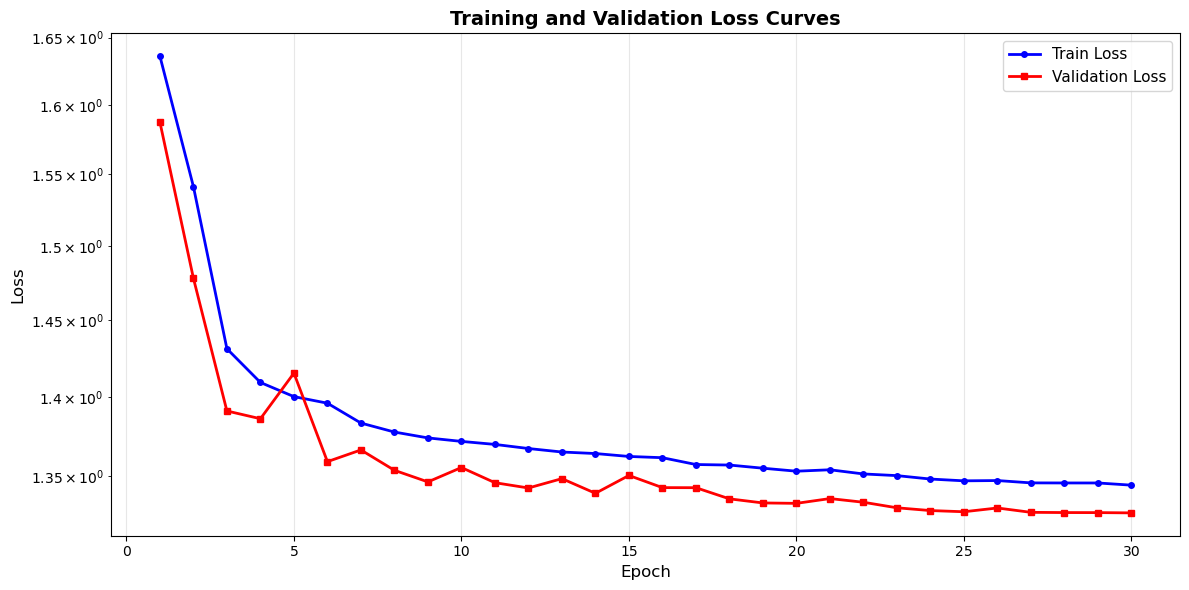

Final Training Loss: 1.3446
Final Validation Loss: 1.3277
Best Validation Loss: 1.3277 (Epoch 30)


In [13]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue', linewidth=2, marker='o', markersize=4)
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red', linewidth=2, marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization of loss curves
plt.tight_layout()
plt.show()

# Print final loss values
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")

## Step 6: Evaluating the model and visualizing results

In [14]:
def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_targets = []
    test_loss = 0
    
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Evaluating"):
            sequences, labels = sequences.to(device), labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs.reshape(-1, NUM_CLASSES), labels.reshape(-1))
            test_loss += loss.item()
            
            predictions = outputs.argmax(dim=-1)
            mask = (labels != PAD_IDX)
            
            # Collect predictions and targets for each sequence
            for i in range(sequences.size(0)):
                seq_mask = mask[i]
                seq_preds = predictions[i][seq_mask].cpu().numpy()
                seq_targets = labels[i][seq_mask].cpu().numpy()
                
                all_preds.extend(seq_preds)
                all_targets.extend(seq_targets)
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, 
                                 target_names=['Alpha Helix', '3-10 Helix', 'Pi Helix', 
                                             'Beta Strand', 'Beta Bridge', 'Turn', 'Bend', 'Coil'])
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    return accuracy, report, conf_matrix, test_loss / len(test_loader)

# Load best model and evaluate
model.load_state_dict(torch.load('best_transformer_model.pth'))
accuracy, report, conf_matrix, test_loss = evaluate_model(model, test_loader)

print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("\nClassification Report:")
print(report)

/tmp/ipykernel_814468/4198848012.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth'))
Evaluating:   0%|      

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 26.84it/s]


Test Accuracy: 0.5064 (50.64%)
Test Loss: 1.3219

Classification Report:
              precision    recall  f1-score   support

 Alpha Helix       0.42      0.44      0.43     10215
  3-10 Helix       0.00      0.00      0.00       612
    Pi Helix       0.50      0.54      0.52     11847
 Beta Strand       0.00      0.00      0.00      2238
 Beta Bridge       0.00      0.00      0.00         1
        Turn       0.58      0.77      0.66     19552
        Bend       0.31      0.00      0.01      4365
        Coil       0.35      0.30      0.33      6114

    accuracy                           0.51     54944
   macro avg       0.27      0.26      0.24     54944
weighted avg       0.46      0.51      0.46     54944



/home2/yashas.b/miniconda3/envs/binding-pose/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home2/yashas.b/miniconda3/envs/binding-pose/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home2/yashas.b/miniconda3/envs/binding-pose/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

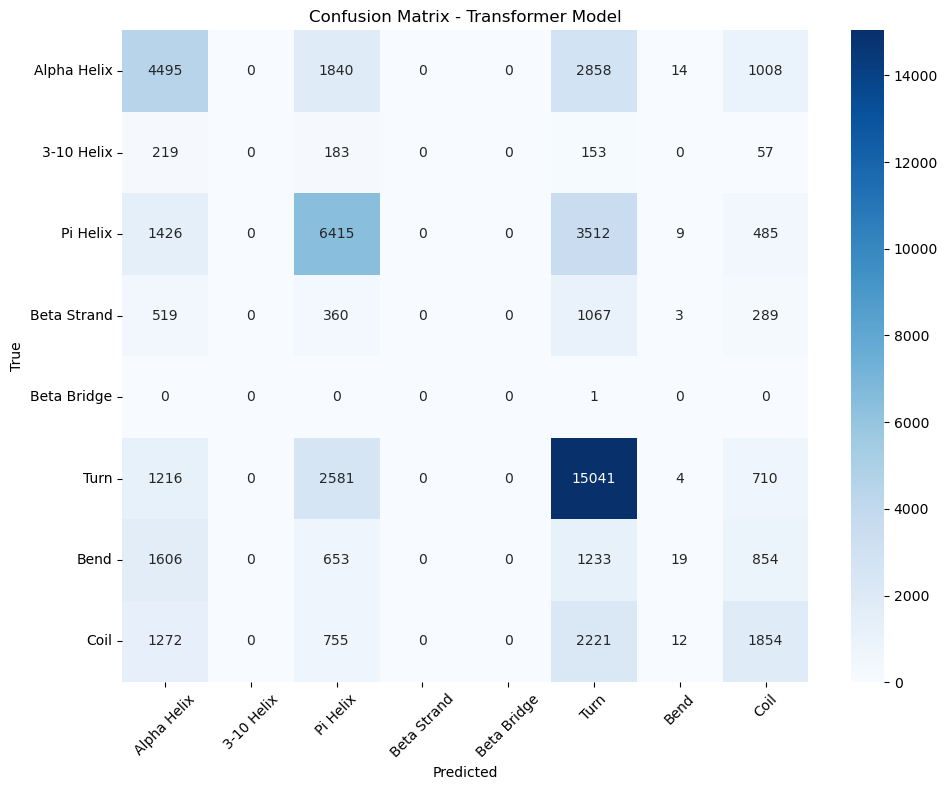

In [15]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Alpha Helix', '3-10 Helix', 'Pi Helix', 'Beta Strand', 
                        'Beta Bridge', 'Turn', 'Bend', 'Coil'],
            yticklabels=['Alpha Helix', '3-10 Helix', 'Pi Helix', 'Beta Strand', 
                        'Beta Bridge', 'Turn', 'Bend', 'Coil'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Transformer Model')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()